In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.functional as F
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from IPython import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [129]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!pip install selfies

x_path = '/content/drive/My Drive/GRU_data/250k_klek.csv'
y_path = '/content/drive/My Drive/GRU_data/250k_selfies.csv'

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data prep

In [130]:
# alphabet of tokens for output

import selfies as sf
data = pd.read_csv(y_path)
alphabet = sf.get_alphabet_from_selfies(data.selfies)
alphabet.add("[start]")
alphabet.add("[end]")
alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))
#pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 10
pad_to_len = 128 # for simplicities' sake
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}
for i, token in enumerate(alphabet):
  print(f'{i}:', token)

0: [#Branch1]
1: [#Branch2]
2: [#C]
3: [#N]
4: [/C]
5: [/N]
6: [/O]
7: [=Branch1]
8: [=Branch2]
9: [=C]
10: [=N+1]
11: [=N]
12: [=O]
13: [=Ring1]
14: [=Ring2]
15: [=S]
16: [Br]
17: [Branch1]
18: [Branch2]
19: [C@@H1]
20: [C@@]
21: [C@H1]
22: [C@]
23: [C]
24: [Cl]
25: [F]
26: [I]
27: [N+1]
28: [NH1]
29: [N]
30: [O-1]
31: [O]
32: [P]
33: [Ring1]
34: [Ring2]
35: [S]
36: [\C]
37: [\N]
38: [\O]
39: [end]
40: [nop]
41: [start]


In [131]:
class ConciousCrossEntropy(nn.Module):
  def __init__(self):
    super(ConciousCrossEntropy, self).__init__();
    self.batch_size = 256
    self.alphabet_len = 42
    self.seq_len = 128
    self.idx_ignore = 40 # index of token to ignore
    self.ignore = torch.zeros(self.alphabet_len)
    self.ignore[self.idx_ignore] = 1

  def forward(self, predictions, target):
    cross_entropy_loss = 0
    for y_true, y in zip(target, predictions):
      sequence_loss = 0
      nops = 0
      for token, true_token  in zip(y_true, y):  
        if torch.equal(true_token, self.ignore):
          nops += 1
        else:
          # we only need predicted probabilities for the correct classes
          # so we can multiply probabilities vector and OHE true token vector
          # to mask out all the others and then sum
          product = torch.mul(token, true_token)
          prob = torch.sum(product)
          # negative logarithm of the predicted probability for the correct class
          loss = -torch.log(prob)
          sequence_loss = torch.add(sequence_loss, loss)
      sequence_loss = sequence_loss/self.seq_len-nops
      cross_entropy_loss += sequence_loss
    loss_value = cross_entropy_loss/self.batch_size
    return loss_value

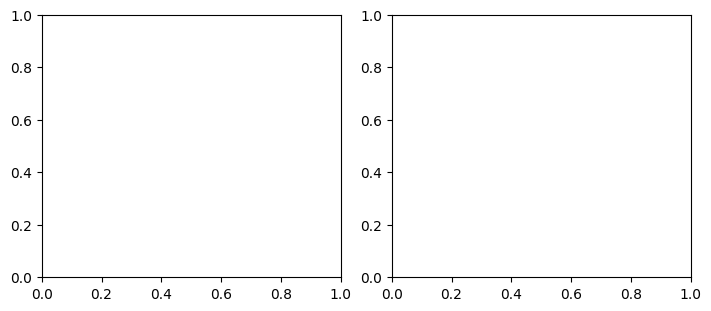

Starting Training of GRU
Device: cpu
Epoch: 1


  2%|▏         | 11/646 [00:39<38:01,  3.59s/it]


KeyboardInterrupt: ignored

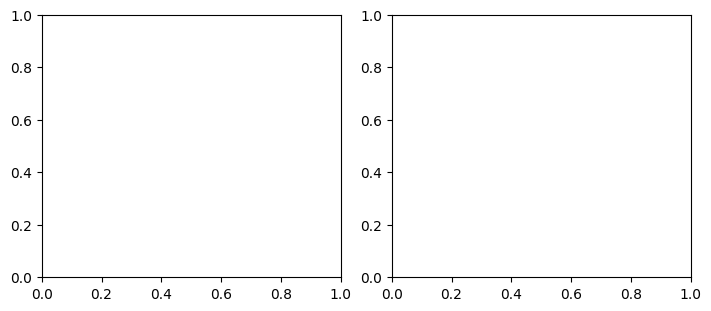

In [127]:
model = train(train_loader, test_loader, device)

In [9]:
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len=None):
        self.alphabet = alphabet
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
        self.pad_to_len = pad_to_len
    def vectorize(self, selfie, no_special=False):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        if no_special:
            splited = self.split_selfi(selfie)
        elif self.pad_to_len is None:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]']
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        X = np.zeros((len(splited), len(self.alphabet)))
        for i in range(len(splited)):
            X[i, self.char2idx[splited[i]]] = 1
        return X
    def devectorize(self, ohe, remove_special=False):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(ohe.shape[0]):
            idx = np.argmax(ohe[j, :])
            if remove_special and (self.idx2char[idx] == '[start]' or self.idx2char[idx] == '[end]'):
                continue
            selfie_str += self.idx2char[idx]
        return selfie_str
    def idxize(self, selfie, no_special=False):
        if no_special:
            splited = self.split_selfi(selfie)
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        return np.array([self.char2idx[s] for s in splited])
    def deidxize(self, idx):
        return "".join([self.idx2char[i] for i in idx])
    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)
vectorizer = SELFIESVectorizer(alphabet, pad_to_len)

In [7]:
from torch.utils.data import Dataset, DataLoader

class GRUDatasetv2(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_csv(smiles_fp)
        self.selfies = pd.read_csv(selfies)
        #self.smiles_fp = pd.read_csv(smiles_fp)
        #self.selfies = pd.read_csv(selfies)
        self.selfies= self.prepare_y(self.selfies)
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.selfies[idx][0]
        vectorized_selfie = self.vectorizer.vectorize(raw_selfie)
        raw_X = self.smiles_fp.fps[idx]
        X = np.array(eval(raw_X), dtype=int)
        X_reconstructed = self.reconstruct_fp(X)
        return torch.from_numpy(X_reconstructed).float(), torch.from_numpy(vectorized_selfie).float()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values
        
    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [10]:
dataset = GRUDatasetv2(x_path, y_path, vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [11]:
print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 183879
Train size: 165491
Test size: 18388


In [12]:
batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

# NN architecture

In [41]:
class EncoderNet(nn.Module):
    def __init__(self, fp_size):
        super(EncoderNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(fp_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        #out.shape = [batch_size, 256]
        return out


class DecoderNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DecoderNet, self).__init__()
        
        # GRU parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # output token count
        self.output_size = output_size

        # pytorch.nn
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        #x.shape = [batch_size, selfie_len, encoding_size] = [64, 128, 256]
        out, h = self.gru(x, h)
        #out.shape = [batch_size, selfie_len, hidden_size] = [64, 128, 256]
        #h.shape = [num_layers, batch_size, hidden_size] = [1, 64, 256]
        return out, h
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return h0

In [58]:
class EncoderDecoder(nn.Module):
    def __init__(self, fp_size=4860, input_size=256, hidden_size=256, num_layers=1, output_size=42):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderNet(fp_size=4860)
        self.decoder = DecoderNet(input_size, hidden_size, num_layers, output_size)
        
        #pytorch.nn
        self.fc = nn.Linear(256, 42)
        self.relu = nn.ReLU()
        self.softmax2d = nn.Softmax(dim=2)
        
    def forward(self, x):
        hidden = decoder.init_hidden(batch_size=x.shape[0]).to(device)
        encoded = self.encoder(x)
        x = encoded.unsqueeze(1)
        decoded = []
        for n in range(128):
            out, hidden = self.decoder(x, hidden)
            x = out
            out = self.relu(self.fc(out))
            decoded.append(out)
        out_cat = torch.cat(decoded, dim=1)
        out_cat = softmax2d(out_cat)
        return out_cat # shape [batch_size, selfie_len, alphabet_len]

#  NN Debugging section

In [44]:
# define encoder and decoder

encoder = EncoderNet(fp_size=4860)
decoder = DecoderNet(input_size=256, hidden_size=256, num_layers=1, output_size=42)

In [45]:
# get test batch, encode and reshape

test_src = next(iter(train_loader))[0]
test_trg = next(iter(train_loader))[1]
encoded = encoder(test_src)
encoded = encoded.unsqueeze(1)
print(f'Encoded shape: {encoded.shape}')
test_trg.shape

Encoded shape: torch.Size([256, 1, 256])


torch.Size([256, 128, 42])

In [48]:
model = EncoderDecoder()
model = model.to(device)
test_src = next(iter(train_loader))[0].to(device)
test_trg = next(iter(train_loader))[1].to(device)
print(f'Src shape: {test_src.shape}')
print(f'Trg shape: {test_trg.shape}')

Src shape: torch.Size([256, 4860])
Trg shape: torch.Size([256, 128, 42])


In [49]:
outputs = model(test_src)
print(f'Outputs shape: {outputs.shape}')

output = torch.argmax(outputs, dim=2)
output = output.cpu().detach().numpy()
print(f'Outputs shape after argmax: {output.shape}')
outputs[0]

Outputs shape: torch.Size([256, 128, 42])
Outputs shape after argmax: (256, 128)


tensor([[0.0234, 0.0234, 0.0236,  ..., 0.0234, 0.0241, 0.0244],
        [0.0233, 0.0233, 0.0234,  ..., 0.0233, 0.0238, 0.0243],
        [0.0233, 0.0233, 0.0233,  ..., 0.0233, 0.0235, 0.0242],
        ...,
        [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0246],
        [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0246],
        [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0246]],
       grad_fn=<SelectBackward0>)

In [ ]:
# see SELFIES
selfies = []
for selfie in output[:5]:
    vectorized = []
    for token in selfie:;
        v = np.zeros(42)
        v[token] = 1
        vectorized.append(v)
    vectorized = np.array(vectorized)
    selfie = vectorizer.devectorize(vectorized)
    selfies.append(selfie)
for selfie in selfies:
    print(selfie, '\n')

[NH1][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start][start] 

[NH1][start][start][start][start][start][start][start][start][start][start][start][start][start][start]

# Training loop

In [97]:
from IPython import display

def train(train_loader, test_loader, device):

    # Setting common hyperparameters
    EPOCHS = 10
    input_size = 256
    hidden_size = 256
    n_layers = 1
    output_size = 42
    learn_rate = 0.001
    
    # Define dataframe for training progess display
    epochs_range = range(1,EPOCHS+1)
    metrics = pd.DataFrame();
    metrics['epoch'] = epochs_range
    
    # Define pyplot for plotting metrics
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display.display(fig, display_id=True)
    
    # Instantiating the model
    model = EncoderDecoder().to(device)
    
    # Defining loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = ConciousCrossEntropy()
    model.train()
    print("Starting Training of GRU")
    print(f"Device: {device}")
    
    # Start training loop
    for epoch in epochs_range:
        print(f'Epoch: {epoch}')
        epoch_loss = 0
        
        for batch_idx, (X,y) in enumerate(tqdm(train_loader)):
            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(y, output)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        val_loss = evaluate(model, test_loader)
        model.train()

        # Update metrics df
        metrics = metrics.append({'epoch': epoch, 'train_loss': avg_loss, 
                                  'val_loss': val_loss}, ignore_index=True)
        
        # Display metrics
        ax[0].clear()
        ax[0].plot(metrics.epoch, metrics.train_loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('CrossEntropy')
        ax[1].clear()
        ax[1].plot(metrics.epoch, metrics.val_loss)
        ax[1].set_title('validation loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('CrossEntropy')
        dh.update(fig)
    plt.close()
    return model

def evaluate(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    epoch_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = criterion(output, y)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(test_loader)
    return avg_loss

# Init and train the model

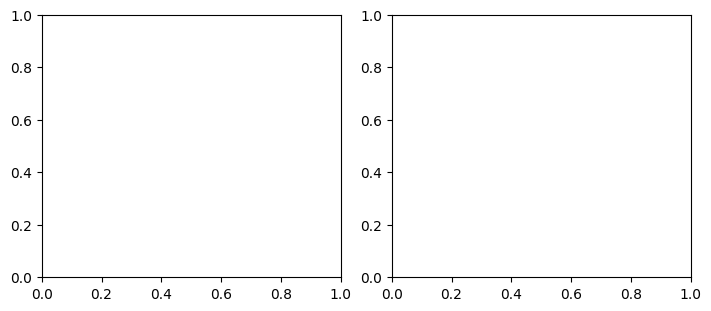

Starting Training of GRU
Device: cpu
Epoch: 1


  0%|          | 0/646 [00:00<?, ?it/s]

Nops: 128
Self ignore: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


ZeroDivisionError: ignored

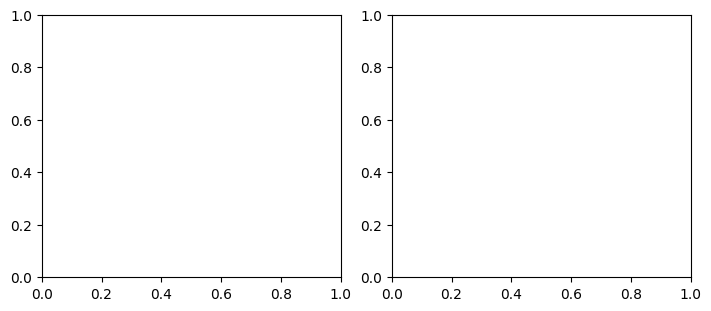

In [98]:
model = train(train_loader, test_loader, device)

In [ ]:
# save model just in case
torch.save(model.state_dict(), './GRU_data/test1.pt')

In [ ]:
#loaded_model = Autoencoder(4860, 300, 300, 42, 2, 0.0).to(device)
#loaded_model.load_state_dict(torch.load('./GRU_data/model_h300_e500_teacher_forcing.pt'))

In [ ]:
x, y = next(iter(test_loader))
x = x.to(device)
x.size()

In [ ]:
encoded, decoded = loaded_model(x)

# GRU output to SELFIES

In [ ]:
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()

In [ ]:
# set largers value to 1 and others to 0
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()
selfies_out = []
for i, original in zip(decoded_indices, y):
    vectorized = []
    #print(f'Decoded: {i}')
    #convert to one-hot
    for number in i:
        v = np.zeros(42)
        v[number] = 1
        vectorized.append(v)
    vectorized = np.array(vectorized)
    selfies_out.append(vectorizer.devectorize(vectorized, remove_special=True))
    print(f'Original: {vectorizer.devectorize(original.cpu().numpy())} \n')
    print(f'Decoded:  {vectorizer.devectorize(vectorized)}')
    print('------------------')

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = []
for selfie in selfies_out:
    smile = sf.decoder(selfie, attribute=False)
    smiles.append(smile)

ms = []
for smile in smiles:
    ms.append(Chem.MolFromSmiles(smile))
Draw.MolToImage(ms[5], size=(800, 800), kekulize=True)